### Purpose
This research hopes to find a more accurate way of predicting stock prices or the direction of change by trying several machine learning methods, which can bring a return on investment. The subject of the study is XBI, an ETF consisting of small companies in the biotech sector in the U.S. Since small companies in biotech rely heavily on financing, there is a strong relationship between their stock prices and market interest rates. Treasury yields can represent current and projected future market interest rates in the stock market. Therefore, one can combine changes in Treasury yields with XBI's historical prices to predict XBI's future stock price or change direction. We will try several combinations of data and different machine-learning methods to find the best way that can help with investing.

## Prepare Data

In [473]:
import pandas as pd
import numpy as np
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Activation, Dropout, Dense, Reshape, Conv1D, Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import mean_squared_error
import random
%matplotlib inline

In [474]:
# Obtain last 5 years data on Treasury yields
import gdown

In [475]:
gdown.download(f"https://drive.google.com/uc?id=163bKMc1LyetlUJ0lEoyMPof0Bfu-BqMI", output='30years', quiet=True)
gdown.download(f"https://drive.google.com/uc?id=1DpFCPMu5SG2LbuMqry-9nvWUO8mfq-xq", output='10years', quiet=True)
gdown.download(f"https://drive.google.com/uc?id=1JQIJDiEAclEM1NyfM5K8wTU2h9OaZPL1", output='5years', quiet=True)


'5years'

In [476]:
# 30 year Treasry yield
df30 = pd.read_csv('30years')
# 10 year Treasry yield
df10 = pd.read_csv('10years')
# 5 year Treasry yield
df5 = pd.read_csv('5years')
# shape of one data frame
df30.shape

(1518, 7)

In [477]:
# show head of one data frame
df10.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-29,3.094,3.117,3.085,3.087,3.087,0.0
1,2018-10-30,3.117,3.123,3.094,3.110,3.110,0.0
2,2018-10-31,3.149,3.161,3.134,3.159,3.159,0.0
3,2018-11-01,3.164,3.174,3.136,3.144,3.144,0.0
4,2018-11-02,3.155,3.216,3.155,3.214,3.214,0.0


In [478]:
# we only keep Date and Adj Close value
df30 = df30[['Date','Adj Close']]
df30.columns = ['Date', 'Y30']
# only keep Adj Close value and rename the column
df10 = df10[['Adj Close']]
df10.columns = ['Y10']
# only keep Adj Close value and rename the column
df5 = df5[['Adj Close']]
df5.columns = ['Y5']
# merge the data into one dataframe
dft = pd.concat([df30, df10, df5], axis=1)
# show head
dft.head()

,Date,Y30,Y10,Y5
0,2018-10-29,3.329,3.087,2.919
1,2018-10-30,3.356,3.110,2.939
2,2018-10-31,3.402,3.159,2.987
3,2018-11-01,3.387,3.144,2.968
4,2018-11-02,3.453,3.214,3.038


In [479]:
# get XBI data for last 5 years
gdown.download(f"https://drive.google.com/uc?id=1TlIP4mEWxys23DZ_3kej7tHN8cZ6nUzO", output='Xbi', quiet=True)
dfxbi = pd.read_csv('Xbi')
# only keep Date and Adj Close
dfxbi = dfxbi[['Date', 'Adj Close']]
dfxbi.columns = ['Date', 'Xbi']
# display the shape of xbi
dfxbi.head()

,Date,Xbi
0,2018-10-29,77.714813
1,2018-10-30,78.153656
2,2018-10-31,78.901680
3,2018-11-01,83.519493
4,2018-11-02,83.738914


dfxbi and tdf has different size, we need to align them first

In [480]:
# merge dft and dfxbi
dfX = dft.merge(dfxbi, on='Date', how='inner')
# print the shape of the dataframe
print(dfX.shape)
# show head of dfX
dfX.head(5)

(1258, 5)


,Date,Y30,Y10,Y5,Xbi
0,2018-10-29,3.329,3.087,2.919,77.714813
1,2018-10-30,3.356,3.110,2.939,78.153656
2,2018-10-31,3.402,3.159,2.987,78.901680
3,2018-11-01,3.387,3.144,2.968,83.519493
4,2018-11-02,3.453,3.214,3.038,83.738914


In [481]:
# get the close price of each columns
p30 = dfX['Y30'].to_numpy()
p10 = dfX['Y10'].to_numpy()
p5 = dfX['Y5'].to_numpy()
pxbi = dfX['Xbi'].to_numpy()
# create a data list
dfs_raw = [['30 years treasury yield', p30], ['10 years treasury yield',p10], ['5 years treasury yield', p5], ['Xbi Price', pxbi]]

In [482]:
# plot the data
def display(data):
    fig, ax = plt.subplots(figsize=(10, 5))
    # plt.figure(figsize=(10, 5))
    # Use a custom color for each of our companies
    colors = ['b', 'c', 'r', 'g']
    date_label = [datetime.strptime(date, '%Y-%m-%d') for date in dfX["Date"].to_numpy()]
    ax.plot(date_label, data[1], label=data[0], color=colors[dfs_raw.index(data) % len(colors)])

    # Adding the labels and titles
    ax.set_xlabel("Date")
    # set x label interval
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=len(date_label) // 5))
    # plt.xticks(np.arange(0, len(date_label), len(date_label)//10))

    ax.set_ylabel("Close Price")
    ax.set_title(f"{data[0]}")

    # Adding the legend
    ax.legend()

    # Adding some grid lines
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.show()

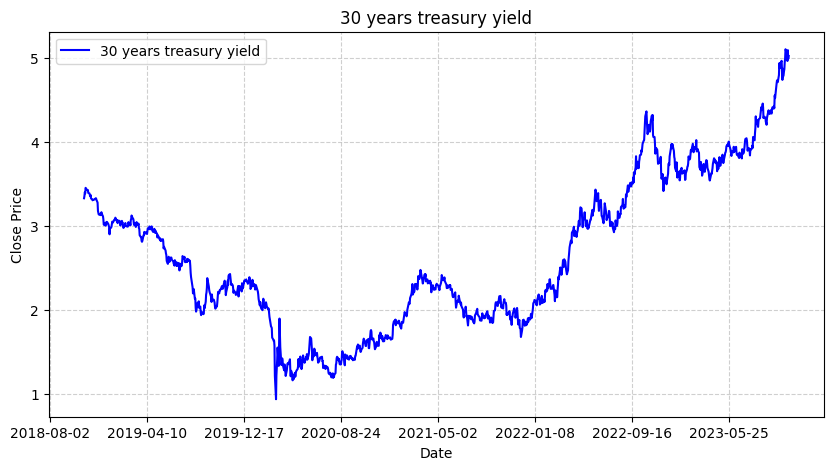

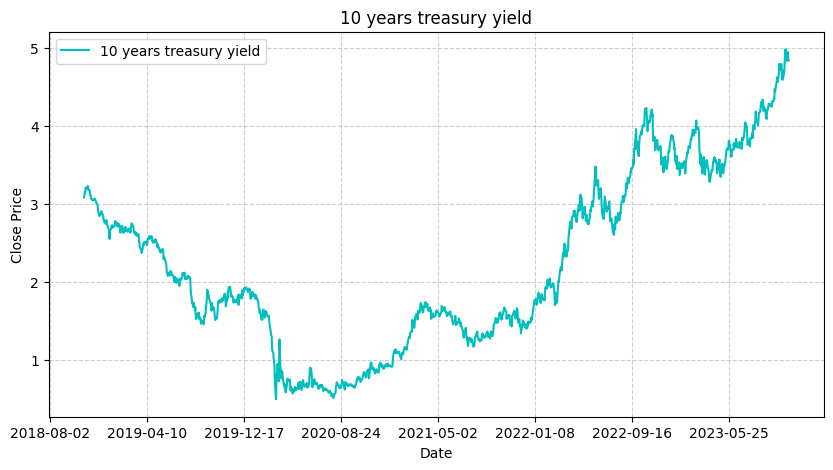

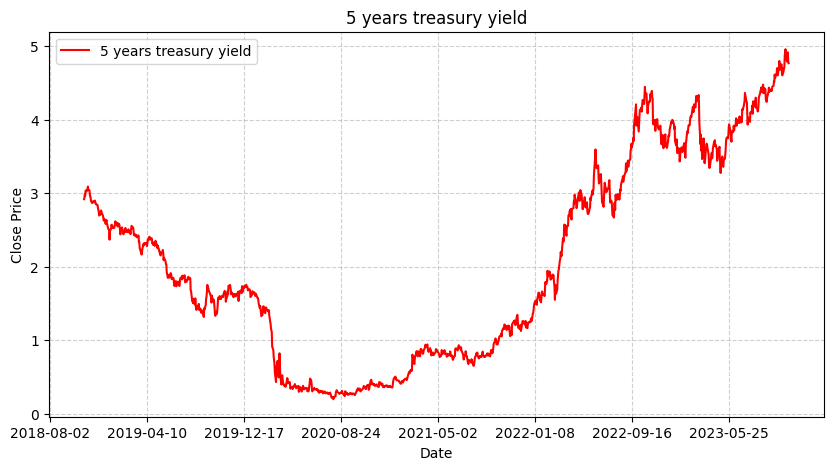

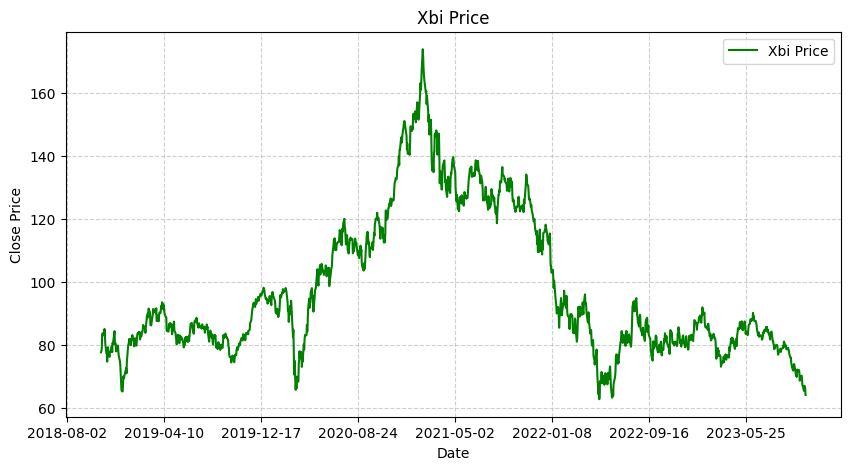

In [483]:
for data in dfs_raw:
  display(data)

scaling the data

In [484]:
scalers = []
scaled_data = [ p30, p10, p5, pxbi].copy()
for i in range(4):
  scaler = MinMaxScaler()
  scaled_data[i] = scaler.fit_transform(scaled_data[i].reshape(-1,1)).reshape(-1)
  scalers.append(scaler)

In [485]:
scalers[3].n_features_in_

1

In [486]:
# show scaled data of p30
scaled_data[0]

array([0.57417187, 0.5806529 , 0.59169467, ..., 0.99735958, 0.97239558,
       0.98079693])

In [487]:
# define a function to merge p30, p10, p5 and pxbi into a vector of price
def merge_price(chosen=[1,1,1,1]):
  merged = [ scaled_data[i] for i in range(4) if chosen[i] == 1 ]
  merged =  [[item[i] for item in merged] for i in range(len(merged[0]))]
  return merged
# define a function to show shape of list data
def show_shape(data):
  print(f'Current data has a shape of {len(data)} x {len(data[0])}')
  print(f'First item in data is:\n {data[0]}')


In [488]:
# convert all data into 4-dimension[p30, p10, p5, xbi] vectors
X = merge_price()
# show shape of X
show_shape(X)

Current data has a shape of 1258 x 4
First item in data is:
 [0.5741718674987999, 0.5765203831588327, 0.5715484683172471, 0.1341419673689207]


In [489]:
# y is the last column in scaled_data
y = scaled_data[3].tolist()

In [490]:
# use look_back days price to do the forecast
look_back = 20
# forecast next 2 days price
next_days = 2

In [491]:
def shift_data(X, y, look_back = look_back, next_days = next_days):
  dfy = pd.DataFrame({'next_days': y})
  dfx = pd.DataFrame({'look_back': X})
  # prepare input data X by doing date shift
  # get different columns start with shifted look_back + next_days -1 to next_days days in past
  data = [dfx.shift(i) for i in range(look_back + next_days -1, next_days -1, -1)]
  # don't shift y as the textbook did
  data.append(dfy)
  # combine X and y together and drop NA rows
  X= pd.concat(data, axis=1).dropna(axis=0)
  # get y after drop NA rows
  y = X.iloc[:,-1]
  # get X after drop NA rows
  X = X.iloc[:,:-1]
  # return as a numpy array
  return X.values.tolist(), y.to_numpy()

In [492]:
# shift X and align with y
shifted_X, shifted_y = shift_data(X, y)
# show shape of shifted_X
show_shape(shifted_X)

Current data has a shape of 1237 x 20
First item in data is:
 [[0.5741718674987999, 0.5765203831588327, 0.5715484683172471, 0.1341419673689207], [0.5806529044647144, 0.581644018712408, 0.575744859420898, 0.1380909460563966], [0.5916946711473837, 0.5925595901091556, 0.5858161980696601, 0.14482212516537318], [0.5880940950552089, 0.5892180886611718, 0.5818296265211917, 0.18637604107550465], [0.6039366298607778, 0.6048117620850968, 0.5965169953839697, 0.18835052591993573], [0.5988958233317332, 0.6019157941635107, 0.5939991607217792, 0.18431182205399532], [0.5974555928948633, 0.6048117620850968, 0.5990348300461602, 0.18188854034357982], [0.5972155544887182, 0.6045889953218979, 0.6013428451531683, 0.200735705069784], [0.5976956313010082, 0.6092670973490755, 0.607427612253462, 0.19059414130669072], [0.5892942870859338, 0.5992425930051236, 0.597775912715065, 0.1598103153395941], [0.5880940950552089, 0.5985742927155268, 0.5967268149391524, 0.13180841983558322], [0.5832933269323093, 0.5894408554

In [493]:
def get_train_val(x,y):
  # get data size
  data_size = len(x)
  # split the data into training and validation
  split = int(data_size * 0.8)
  Xtrain = tf.convert_to_tensor(x[:split], dtype=tf.float32)
  ytrain = tf.convert_to_tensor(y[:split], dtype=tf.float32)
  Xval = tf.convert_to_tensor(x[split:], dtype=tf.float32)
  yval = tf.convert_to_tensor(y[split:], dtype=tf.float32)
  return Xtrain, ytrain, Xval, yval

In [494]:
# get train and val data
Xtrain, ytrain, Xval, yval = get_train_val(shifted_X, shifted_y)
Xtrain.shape

TensorShape([989, 20, 4])

Model 1:
Focaset the next days closing price of XBI

In [495]:
# a function to set random state
def set_state(seed=66):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
# a helper function to add RNN or LSTM
def add_rnn_lstm(model, n=64, RNN=True, return_sequences=False):
  if RNN:
    model.add(SimpleRNN(n, return_sequences=return_sequences))
  else:
    model.add(LSTM(n, return_sequences=return_sequences))

In [496]:
# define a function to set and compile a machine learning model
def get_model(n_of_features=4, RNN=True, look_back=look_back, n_of_rnn=2, cov_1d=False, change_mode=False, show_summary= False):
  set_state()
  m = Sequential()
  # add a reshape layer
  m.add(Reshape((look_back, n_of_features), input_shape = (look_back, n_of_features)))
  # add Conv1D layer
  if cov_1d:
    m.add(Conv1D(10, 3, activation='relu'))

  if n_of_rnn == 1:
  # add a RNN or LSTM layer
    add_rnn_lstm(m,64,RNN)
  else:
    # add 2 RNN or LSTM layers
    add_rnn_lstm(m,64,RNN,True)
    # add another RNN layer
    add_rnn_lstm(m,32,RNN)

  # add dropout layer
  m.add(Dropout(0.25))

  # # create output layer
  m.add(Dense(1))

  # change_mode=True means to predict the direction of change of the stock price
  # otherwise predict the stock price itself
  if change_mode:
    m.add(Activation('sigmoid'))
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  else:
    m.add(Activation('linear'))
    m.compile(loss='mean_squared_error', optimizer='adam')

  if show_summary:
    m.summary()
  return m

In [497]:
# use all 4 price featues, 2 RNN layers, without cov_1d
model_1 = get_model(show_summary= True)

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_87 (Reshape)        (None, 20, 4)             0         
                                                                 
 simple_rnn_173 (SimpleRNN)  (None, 20, 64)            4416      
                                                                 
 simple_rnn_174 (SimpleRNN)  (None, 32)                3104      
                                                                 
 dropout_89 (Dropout)        (None, 32)                0         
                                                                 
 dense_96 (Dense)            (None, 1)                 33        
                                                                 
 activation_94 (Activation)  (None, 1)                 0         
                                                                 
Total params: 7553 (29.50 KB)
Trainable params: 7553 

In [498]:
# define a helper function
def train_model(model, X, y, epochs = 50, batch_size = 32, verbose = 2):
  set_state()
  model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0)
train_model(model_1, Xtrain, ytrain)

Epoch 1/50
31/31 - 3s - loss: 0.0468 - 3s/epoch - 110ms/step
Epoch 2/50
31/31 - 0s - loss: 0.0137 - 303ms/epoch - 10ms/step
Epoch 3/50
31/31 - 0s - loss: 0.0092 - 318ms/epoch - 10ms/step
Epoch 4/50
31/31 - 0s - loss: 0.0095 - 314ms/epoch - 10ms/step
Epoch 5/50
31/31 - 0s - loss: 0.0061 - 333ms/epoch - 11ms/step
Epoch 6/50
31/31 - 0s - loss: 0.0058 - 336ms/epoch - 11ms/step
Epoch 7/50
31/31 - 0s - loss: 0.0052 - 303ms/epoch - 10ms/step
Epoch 8/50
31/31 - 0s - loss: 0.0044 - 308ms/epoch - 10ms/step
Epoch 9/50
31/31 - 0s - loss: 0.0043 - 293ms/epoch - 9ms/step
Epoch 10/50
31/31 - 0s - loss: 0.0054 - 306ms/epoch - 10ms/step
Epoch 11/50
31/31 - 0s - loss: 0.0043 - 296ms/epoch - 10ms/step
Epoch 12/50
31/31 - 0s - loss: 0.0044 - 303ms/epoch - 10ms/step
Epoch 13/50
31/31 - 0s - loss: 0.0039 - 305ms/epoch - 10ms/step
Epoch 14/50
31/31 - 0s - loss: 0.0036 - 301ms/epoch - 10ms/step
Epoch 15/50
31/31 - 0s - loss: 0.0039 - 295ms/epoch - 10ms/step
Epoch 16/50
31/31 - 0s - loss: 0.0038 - 315ms/epoch 

In [499]:
# create a evaluation function
import math
def get_model_perf(model, X, Y):
  score = math.sqrt(model.evaluate(X, Y, verbose=0))
  print('RMSE: %.3f\n' % (score))
  return score

def predict(model, X, scaler=None):
  if scaler == None:
    return model.predict(X)
  return scaler.inverse_transform(model.predict(X))

def relative_error(pred, real):
  if len(pred) != len(real):
    print("Error: Length of pred and real is not the same")
    return None
  err_rate = np.array( [abs(pred[i]/real[i] -1) for i in range(len(pred))]).mean()
  print(f"The relative error rate is {err_rate*100:.1f}%")
  return err_rate


In [500]:
# show RMSE value on validation data
RMSE = get_model_perf(model_1, Xval, yval)

RMSE: 0.023



In [501]:
def xbi_relative_error(model):
  # get the scaler for Xbi
  scaler = scalers[3]
  # get the predic price for the validation data
  pred_xbi = predict(model, Xval, scaler).reshape(-1)
  # get the real price of the validation data
  val_xbi = scaler.inverse_transform(np.array(yval).reshape(1,-1)).reshape(-1)
  # get the relative error rate for prediction
  relative_err = relative_error(pred_xbi, val_xbi)
  return pred_xbi, val_xbi

In [502]:
pred_xbi, val_xbi = xbi_relative_error(model_1)

8/8 [==============================] - 0s 5ms/step
The relative error rate is 2.6%


In [503]:
def plot_pred(pred, real, start_pos=0, end_pos=-1):
    if len(pred) > len(real):
      print("Error: length of pred is larger than the length of real")
      return
    # if end_pos is -1, set to end_pos to the end of the data
    end_pos = end_pos if end_pos != -1 else len(real)
    # set data in real to plot
    real_to_plot = real[start_pos : end_pos]
    # set prediction data to plot
    pred_to_plot = pred[start_pos : end_pos]
    plt.plot(real_to_plot)
    plt.plot(pred_to_plot, "--")

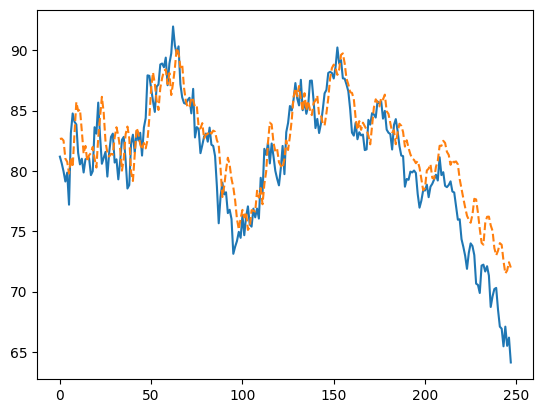

In [504]:
# plot the prediction vs the real closing price
plot_pred(pred_xbi, val_xbi)


The prediction for the closing price over the next 3 days is not very accurate. On average, there's about a 2.6% difference from the actual value, which is less than ideal. However, we shall see if using treasury data is helpful for the prediction. So we can try only using the XBI's own history data to do the prediction.



In [505]:
def test_model(chosen=[0,0,0,1], n_of_features=1, look_back=20, next_days=2, RNN=True, cov_1d=False, show_summary=True):
  look_back = look_back
  next_days = next_days
  # only choose xbi price as the feature
  X_xbi = merge_price(chosen)
  # shift data
  shifted_X, shifted_y = shift_data(X_xbi, y)
  # get train val data
  Xtrain, ytrain, Xval, yval = get_train_val(shifted_X, shifted_y)
  # get the model
  model = get_model(n_of_features=n_of_features, RNN = RNN, cov_1d=cov_1d, show_summary=show_summary)
  # train model
  train_model(model, Xtrain, ytrain, verbose = 0)
  # evaluate the model
  RMSE = get_model_perf(model, Xval, yval)
  return Xval, model, RMSE

In [506]:
Xval, m1, RMSE1 = test_model()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_88 (Reshape)        (None, 20, 1)             0         
                                                                 
 simple_rnn_175 (SimpleRNN)  (None, 20, 64)            4224      
                                                                 
 simple_rnn_176 (SimpleRNN)  (None, 32)                3104      
                                                                 
 dropout_90 (Dropout)        (None, 32)                0         
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
 activation_95 (Activation)  (None, 1)                 0         
                                                                 
Total params: 7361 (28.75 KB)
Trainable params: 7361 

In [507]:
pred_xbi, val_xbi = xbi_relative_error(m1)

8/8 [==============================] - 0s 5ms/step
The relative error rate is 1.9%


It seems only use history XBI price to predict future price are more arrurate then combing with Treasury price (p30). We will see what is the result only using one Treasury price.

In [508]:
_, m2, RMSE2 = test_model(chosen=[1,0,0,1], n_of_features=2)

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_89 (Reshape)        (None, 20, 2)             0         
                                                                 
 simple_rnn_177 (SimpleRNN)  (None, 20, 64)            4288      
                                                                 
 simple_rnn_178 (SimpleRNN)  (None, 32)                3104      
                                                                 
 dropout_91 (Dropout)        (None, 32)                0         
                                                                 
 dense_98 (Dense)            (None, 1)                 33        
                                                                 
 activation_96 (Activation)  (None, 1)                 0         
                                                                 
Total params: 7425 (29.00 KB)
Trainable params: 7425 

It got a worse result when using p30 combined with XBI price. We will try to use LSTM to replace the RNN model to see the result.

In [509]:
Xval, m3, RMSE3 = test_model(RNN=False)

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_90 (Reshape)        (None, 20, 1)             0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_92 (Dropout)        (None, 32)                0         
                                                                 
 dense_99 (Dense)            (None, 1)                 33        
                                                                 
 activation_97 (Activation)  (None, 1)                 0         
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29

In [510]:
Xval, m4, RMSE4 = test_model(cov_1d=True)

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_91 (Reshape)        (None, 20, 1)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 10)            40        
                                                                 
 simple_rnn_179 (SimpleRNN)  (None, 18, 64)            4800      
                                                                 
 simple_rnn_180 (SimpleRNN)  (None, 32)                3104      
                                                                 
 dropout_93 (Dropout)        (None, 32)                0         
                                                                 
 dense_100 (Dense)           (None, 1)                 33        
                                                                 
 activation_98 (Activation)  (None, 1)              

The LSTM model and the model with Cov_1D appear to exhibit slightly inferior performance compared to the RNN model without Cov_1D. Now, we can assess the potential for a satisfactory return based on our best prediction model so far. Let's consider a scenario where we predict a price two days later that exceeds today's price. If the actual price does increase in the next two days, it indicates that the prediction could result in a return. To evaluate the effectiveness of this model in generating returns based on predictions, we can examine the percentage of accurate predictions.

In [513]:
def pred_change_accuracy(pred, actual, next_days):
  result = np.array([1 if (pred[i] >= actual[i-next_days])  == (actual[i] >= actual[i-next_days]) else 0 for i in range(next_days, len(pred))])
  accuracy = result.mean()
  print(f'Accuracy in predict the price change is {accuracy*100:.1f}%')
  return result, accuracy

In [514]:
result, accuracy = pred_change_accuracy(pred_xbi, val_xbi, 2)

Accuracy in predict the price change is 45.5%



Despite employing the best model we have so far, the accuracy of correctly predicting price changes remains below 50%. This implies that relying on this model alone may not yield a satisfactory return. Hence, we aim to explore an alternative approach to determine whether we can identify a model that might yield a satisfactory return.

# Model 2
Now, we will examine the possibility of constructing a model to forecast the direction of future price changes. To accomplish this, it is necessary to first adjust the data labels for both training and validation sets. We still combine the Treasury price ant XBI price as the input features. Because if we find a workable model, it is easy to change to only using XBI's past price as the input feature.

In [515]:
# use p30, p10, p5, pxbi 4 featues
X = merge_price([1,1,1,1])
show_shape(X)

Current data has a shape of 1258 x 4
First item in data is:
 [0.5741718674987999, 0.5765203831588327, 0.5715484683172471, 0.1341419673689207]


In [516]:
# set look_back = 20, next_days = 3
look_back = 20
next_days = 3
# get shifted_X and shifted_y
shifted_X, shifted_y = shift_data(X, y, look_back, next_days)
# display shape of shifted_y
shifted_y.shape

(1236,)

In [517]:
# a helper function to get the price change value
def get_diff(shifted_y, y, look_back):
  new_y = y[next_days:]
  # new_y[i] = y[i + next_days], and get their change into diff_y
  diff_y = [ 1 if shifted_y[i] > y[ i + look_back-1] else 0 for i in range(len(shifted_y))]
  return diff_y

In [518]:
# new label, when actual price increase set to 1 otherwise set to 0
new_y = get_diff(shifted_y, y, look_back)
# show first 5 item in new_y
new_y[:5]

[1, 1, 1, 1, 0]

In [519]:
# convert train and validation label into tensor
Xtrain, ytrain, Xval, yval = get_train_val(shifted_X, new_y)
# show shape of Xtrain
Xtrain.shape

TensorShape([988, 20, 4])

In [520]:
# create RNN model
change_model = get_model(change_mode=True)

In [521]:
# train model
train_model(change_model, Xtrain, ytrain, epochs=100, verbose=0)

In [522]:
# get the prediction
diff_pred = predict(change_model, Xval)

8/8 [==============================] - 0s 4ms/step



Here, we can employ a "safe" prediction model. The output layer utilizes a sigmoid activation function, where a larger output value indicates a higher likelihood of the prediction being equal to "1". By selecting a threshold, we can predict the label as "1" only when the value exceeds the threshold. This approach is expected to yield a more accurate prediction (We're not focusing on how accurately we predict price decreases for now.)

In [523]:
# set 0.8 as the threshold for safe prediction
limit = 0.8
# get safe prediction
safe_pred = np.array([ 1 if val > limit else 0 for val in diff_pred])
# get how many safe prediction we made
total_predictions = safe_pred.sum()
# show safe predict numbers
print(f'Total {total_predictions} safe predictions made in the validation data.')

Total 23 safe predictions made in the validation data.


In [524]:
# get total right predictions
right_pred = np.array([1 if (safe_pred[i] == 1 and new_y[i]==1) else 0 for i in range(len(diff_pred))])
right_number = right_pred.sum()
print(f'Total {right_number} predictions are correct in safe predictions')

Total 19 predictions are correct in safe predictions


In [525]:
# we got 19 right prediction out of 23, the forecast accuracy is
print(f'The accuracy in safe predictions is {right_number/total_predictions*100:.1f}%')


The accuracy in safe predictions is 82.6%


This is not a bad result and we can see if we change the threshold, the forecast accuracy changed reasonably.

In [526]:
# define a function to report accuracy based on threshold value
def check_accuracy_on_threshold(threshold, pred, y):
  safe_pred = np.array([ 1 if val > threshold else 0 for val in pred])
  n_of_safe_pred = safe_pred.sum()
  right_forecast = np.array([1 if (safe_pred[i] == 1 and y[i]==1) else 0 for i in range(len(pred))])
  accuracy = right_forecast.sum() / (safe_pred.sum() + 0.0000001)
  print(f'The forecast accuracy on threshold={threshold} is {accuracy*100:.1f}%, made {n_of_safe_pred} safe predictions')
  return accuracy

In [527]:
# show accuracy on different threshold values
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7, 0.8]

for t in thresholds:
  check_accuracy_on_threshold(t, diff_pred, new_y)

The forecast accuracy on threshold=0.0 is 55.6%, made 248 safe predictions
The forecast accuracy on threshold=0.1 is 55.6%, made 248 safe predictions
The forecast accuracy on threshold=0.2 is 55.6%, made 248 safe predictions
The forecast accuracy on threshold=0.3 is 55.6%, made 248 safe predictions
The forecast accuracy on threshold=0.4 is 55.6%, made 248 safe predictions
The forecast accuracy on threshold=0.5 is 55.5%, made 236 safe predictions
The forecast accuracy on threshold=0.6 is 58.2%, made 134 safe predictions
The forecast accuracy on threshold=0.7 is 62.9%, made 62 safe predictions
The forecast accuracy on threshold=0.8 is 82.6%, made 23 safe predictions


### Observasion
The calculations above indicate that as the threshold surpasses 0.5, the accuracy rises in conjunction with the threshold value. This implies that by elevating the threshold, we can obtain predictions with greater accuracy. However, this also results in a reduction in the number of safe predictions.

We'll experiment to see if adjusting the values for look_back and next_days can improve performance.

In [528]:
test_range = np.array([[20,20], [20,10], [10,10], [10,5]])
# test_range = [(10,10), (10,5)]
models = []
preds = []
ys = []
number_of_predictions = []
number_of_right_predictions = []
accuracy = []
shreshold = 0.8
def test_change_model(shreshold=shreshold, show_summary=False):
  for look_back, next_days in test_range:
    # shif data based on look_back, next_days
    shifted_X, shifted_y = shift_data(X, y, look_back, next_days)
    # get price change label
    new_y = get_diff(shifted_y, y, look_back)
    ys.append(new_y)
    # get train, val data
    Xtrain, ytrain, Xval, yval = get_train_val(shifted_X, new_y)
    # create model
    model = get_model(change_mode=True, look_back=look_back, show_summary=show_summary)
    # save model to models
    models.append(model)
    # train current model
    train_model(model, Xtrain, ytrain, epochs=50, verbose=0)
    # get prediction
    pred = predict(model, Xval)
    preds.append(pred)
    # get safe predictions
    safe_pred = np.array([ 1 if val > shreshold else 0 for val in pred])
    # get number of safe predictions
    total_predictions = safe_pred.sum()
    number_of_predictions.append(total_predictions)
    # get right predictions
    right_pred = np.array([1 if (safe_pred[i] == 1 and new_y[i] == 1) else 0 for i in range(len(pred))])
    # get number of correct predictions
    right_number = right_pred.sum()
    number_of_right_predictions.append(right_number)
    # add 0.0000001 in case total_predictions is 0
    accuracy.append(f'{right_number/(total_predictions+0.0000001)*100:.1f}')


In [529]:
# try different length of look_back and next_days
test_change_model()

8/8 [==============================] - 0s 5ms/step


In [530]:
score = pd.DataFrame({"Look Back": test_range[:,0], "Next Days": test_range[:,1], "Number of Prediction": number_of_predictions, "Number of Right Prediction" : number_of_right_predictions, "Acuuracy" :accuracy })
score

,Look Back,Next Days,Number of Prediction,Number of Right Prediction,Acuuracy
0,20,20,18,14,77.8
1,20,10,11,11,100.0
2,10,10,0,0,0.0
3,10,5,0,0,0.0



It appears that the best performance is achieved when look_back=20 and next_days=10, with a threshold of 0.8. Let's closely examine this model.

In [531]:
# get the prediction and actual for model with index 1
diff_pred_2 = preds[1]
new_y_2 = ys[1]
for t in thresholds:
  check_accuracy_on_threshold(t, diff_pred_2, new_y_2)

The forecast accuracy on threshold=0.0 is 53.7%, made 246 safe predictions
The forecast accuracy on threshold=0.1 is 53.7%, made 246 safe predictions
The forecast accuracy on threshold=0.2 is 53.7%, made 246 safe predictions
The forecast accuracy on threshold=0.3 is 54.3%, made 243 safe predictions
The forecast accuracy on threshold=0.4 is 51.7%, made 209 safe predictions
The forecast accuracy on threshold=0.5 is 56.8%, made 118 safe predictions
The forecast accuracy on threshold=0.6 is 58.5%, made 65 safe predictions
The forecast accuracy on threshold=0.7 is 100.0%, made 22 safe predictions
The forecast accuracy on threshold=0.8 is 100.0%, made 11 safe predictions


### Best model
Contrasted with the model utilizing look_back=20 and next_days=3, the present model demonstrates superior performance. Particularly noteworthy is that, with a threshold of 0.7, this model attains a perfect 100% accuracy in its predictions. Consequently, the optimal configuration for the model is to set look_back=20, next_days=10, and the threshold to 0.7. In this scenario, if the model predicts an increase in XBI's price over the next 10 days, one could buy XBI at the closing time of the market and sell it at the closing time 10 days later, ensuring a 100% chance of positive returns.

## Summary
By experimenting with various machine learning models and label processing techniques, we could draw the following conclusions:

1. The inclusion of changes in treasury yields does not enhance the accuracy of predictions for XBI stock prices.

2. The utilization of LSTM or convolutional networks does not outperform the use of RNN models.

3. Reprocessing the data, enabling the neural network to learn the direction of stock price changes (up/down), and implementing a specific threshold can enhance prediction accuracy. However, this results in fewer predictions, diminishing potential investment opportunities.

4. Predictions for stock price change directions, exhibit lower accuracy for both shorter (3 days in the future) and longer periods (20 days in the future) compared to the median (10 days in the future).

5. Overall, there is a higher likelihood of achieving a satisfactory return on investment using the stock prediction model, although additional testing and adjustments are necessary.